In [461]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import casacore
import casacore.tables as pt
import pandas as pd
from sklearn import cluster
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
plt.rcParams['figure.figsize']=[10,8]
plt.rcParams['font.size']=14
date='20170804'
#fname = "/data001/scratch/kkozarev/EVENT_20170804/MS/SUN/L602826_SAP000_SB052_uv_autoweight.MS"
basedir='/data/LOFAR/'+date+'/'
fname = basedir+"L602826_SAP000_SB154_uv_autoweight.MS"
outms = basedir+"L602826_SAP000_SB154_uv_autoweight_v1.MS"
savedir=basedir+'viscutoff/'
plotsavedir=basedir

# 1. Generate/Load dataframes with the visibility information for Core Station baselines

In [462]:
run=False
if run is True:
    #Develop pandas dataframes for each cross-correlation before and after calibration
    #They hold the visibilities for all LOFAR baselines over all timesteps of observation.
    #XX,XY,YX,YY
    cdfxx = pd.DataFrame()
    cdfxy = pd.DataFrame()
    cdfyx = pd.DataFrame()
    cdfyy = pd.DataFrame()
    uvwdf = pd.DataFrame()
    #Get the data from the MS for only the core station baselines    
    ant = pt.table(fname+"/ANTENNA").getcol("NAME")
    cs = [i for i,j in enumerate(ant) if "CS" in j] #Select Core stations only
    #Loop over antenna combinations
    for idx1,ant1 in enumerate(cs):
        for ant2 in cs[idx1+1:]:
            column=ant[ant1]+"_"+ant[ant2]
            myt = pt.taql("select from $fname where ANTENNA1==$ant1 and ANTENNA2==$ant2")
            flags = myt.getcol("FLAG")
            datacol = myt.getcol("DATA")
            uvw=myt.getcol("UVW")
            corrected_datacol = myt.getcol("CORRECTED_DATA")
            cdfxx[column]=np.ma.array(corrected_datacol[:,0,0], mask=flags[:,0,0])
            cdfxy[column]=np.ma.array(corrected_datacol[:,0,1], mask=flags[:,0,1])
            cdfyx[column]=np.ma.array(corrected_datacol[:,0,2], mask=flags[:,0,2])
            cdfyy[column]=np.ma.array(corrected_datacol[:,0,3], mask=flags[:,0,3])
            uvwdf[column+'_u']=np.ma.array(uvw[:,0], mask=flags[:,0,0])
            uvwdf[column+'_v']=np.ma.array(uvw[:,1], mask=flags[:,0,0])
            uvwdf[column+'_w']=np.ma.array(uvw[:,2], mask=flags[:,0,0])
    #Corrected data column dataframes
    cdfxx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
    cdfxy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxy.p')
    cdfyx.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdyx.p')
    cdfyy.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdyy.p')
    uvwdf.to_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_uvw.p')

In [463]:
run=True
if run is True:
    #Instead of rerunning above cell, load the pickle files with the data.
    cdfxx=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxx.p')
    cdfxy=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdxy.p')
    cdfyx=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdyx.p')
    cdfyy=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_cdyy.p')
    uvwdf=pd.read_pickle(savedir+'L602826_SAP000_SB154_uv_autoweight_uvw.p')
    cols=[col for col in cdfxx.columns]
    #Define the columns in the dataframe that represent different quantities.
    #U,V,W coordinates
    cols_v=[col for col in uvwdf.columns if '_v' in col]
    cols_u=[col for col in uvwdf.columns if '_u' in col]
    cols_w=[col for col in uvwdf.columns if '_w' in col]
    #The magnitude of the UVW distances - units?
    dr=np.sqrt(uvwdf[cols_v].values[0]*uvwdf[cols_v].values[0]+
               uvwdf[cols_u].values[0]*uvwdf[cols_u].values[0]+
               uvwdf[cols_w].values[0]*uvwdf[cols_w].values[0])

In [464]:
#Calculate the amplitudes and phases of the visibilities in XX, XY, YX, YY correlations
phaxx=pd.DataFrame()
ampxx=pd.DataFrame()
phaxy=pd.DataFrame()
ampxy=pd.DataFrame()
phayx=pd.DataFrame()
ampyx=pd.DataFrame()
phayy=pd.DataFrame()
ampyy=pd.DataFrame()
for col in cols:
    ampxx[col]=np.abs(cdfxx[col])
    phaxx[col]=np.angle(cdfxx[col])
    ampxy[col]=np.abs(cdfxy[col])
    phaxy[col]=np.angle(cdfxy[col])
    ampyx[col]=np.abs(cdfyx[col])
    phayx[col]=np.angle(cdfyx[col])
    ampyy[col]=np.abs(cdfyy[col])
    phayy[col]=np.angle(cdfyy[col])

# 2. Overview plots of the visibility amplitudes and phases versus time and baseline lengths

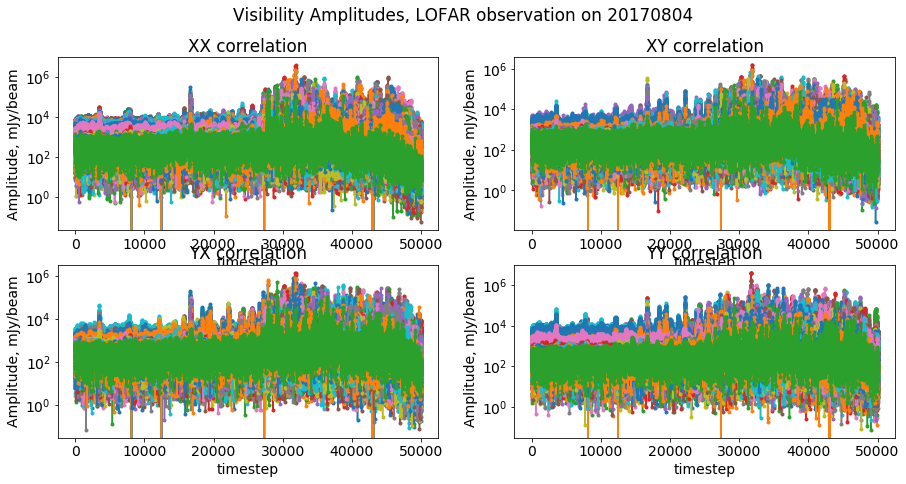

In [270]:
#Plot all the amplitudes
fig=plt.figure(figsize=(15,7))
plt.suptitle('Visibility Amplitudes, LOFAR observation on '+date)
#Plot the magnitude of the XX observations
ax1 = fig.add_subplot(221)
ax1.set_xlabel('timestep')
ax1.set_ylabel('Amplitude, mJy/beam')
for col in cols: plt.plot(ampxx[col].values[0:50000],marker='.')
ax1.set_yscale('log')
ax1.set_title('XX correlation')

#Plot the magnitude of the XY observations
ax2 = fig.add_subplot(222)
ax2.set_xlabel('timestep')
ax2.set_ylabel('Amplitude, mJy/beam')
for col in cols: plt.plot(ampxy[col].values[0:50000],marker='.')
ax2.set_yscale('log')
ax2.set_title('XY correlation')

#Plot the magnitude of the YX observations
ax3 = fig.add_subplot(223)
ax3.set_xlabel('timestep')
ax3.set_ylabel('Amplitude, mJy/beam')
for col in cols: plt.plot(ampyx[col].values[0:50000],marker='.')
ax3.set_yscale('log')
ax3.set_title('YX correlation')

#Plot the magnitude of the YY observations
ax4 = fig.add_subplot(224)
ax4.set_xlabel('timestep')
ax4.set_ylabel('Amplitude, mJy/beam')
for col in cols: plt.plot(ampyy[col].values[0:50000],marker='.')
ax4.set_yscale('log')
ax4.set_title('YY correlation')

plt.savefig(plotsavedir+'corrected_visibility_amplitudes.png')
plt.show()

<ipython-input-276-1af7c27c9122>:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(plotsavedir+'single_baseline_visibility_amplitude.png',bbox_inches='tight')


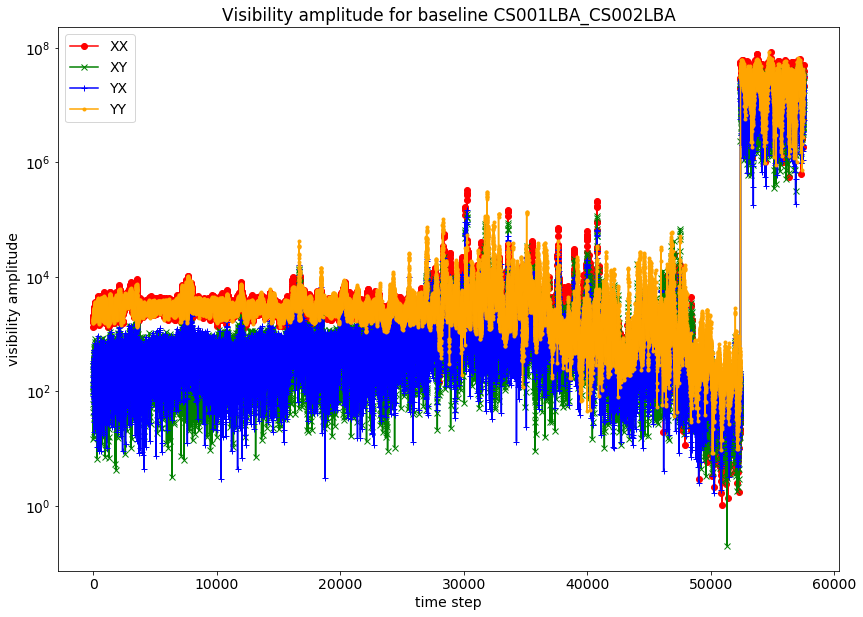

In [276]:
#Plot the time series of corrected visibility amplitudes
col=cols[0]
# different colors is different correlations (XX,XY,YX,YY)
fig=plt.figure(figsize=(14,10))
plt.plot(ampxx[col],marker='o',color='red',label='XX') 
plt.plot(ampxy[col],marker='x',color='green',label='XY')
plt.plot(ampyx[col],marker='+',color='blue',label='YX')
plt.plot(ampyy[col],marker='.',color='orange',label='YY')
plt.title('Visibility amplitude for baseline '+col)
plt.xlabel("time step")
plt.ylabel("visibility amplitude")
plt.yscale('log')
plt.legend()
plt.savefig(plotsavedir+'single_baseline_visibility_amplitude.png',bbox_inches='tight')
plt.show()
plt.close(fig)

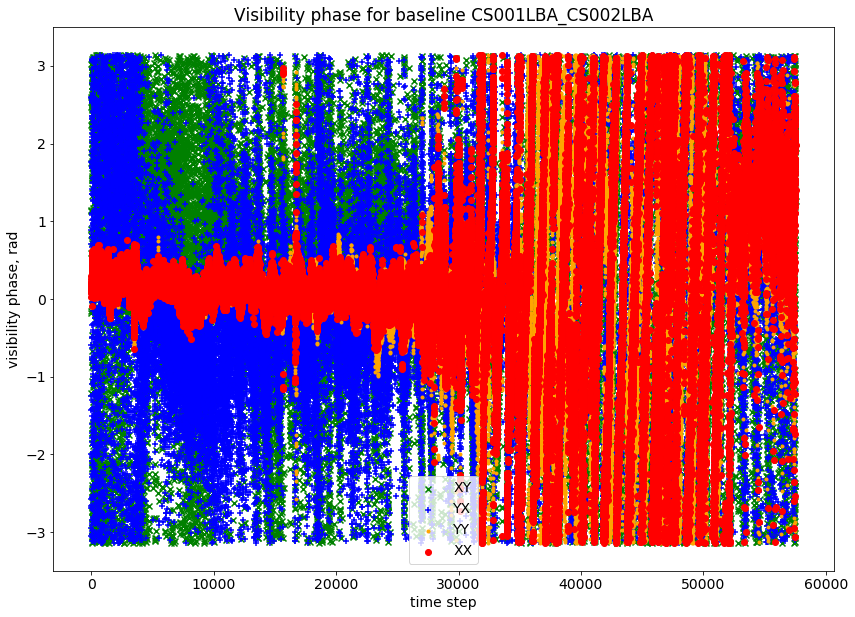

In [277]:
#Plot the time series of corrected visibility amplitudes
fig=plt.figure(figsize=(14,10))
timestepsarr=range(len(phaxx[col]))
plt.scatter(timestepsarr,phaxy[col],marker='x',color='green',label='XY')
plt.scatter(timestepsarr,phayx[col],marker='+',color='blue',label='YX')
plt.scatter(timestepsarr,phayy[col],marker='.',color='orange',label='YY')
plt.scatter(timestepsarr,phaxx[col],marker='o',color='red',label='XX') 
plt.title('Visibility phase for baseline '+col)
plt.xlabel("time step")
plt.ylabel("visibility phase, rad")
plt.legend()
plt.savefig(plotsavedir+'single_baseline_visibility_phase.png',bbox_inches='tight')
plt.show()
plt.close(fig)

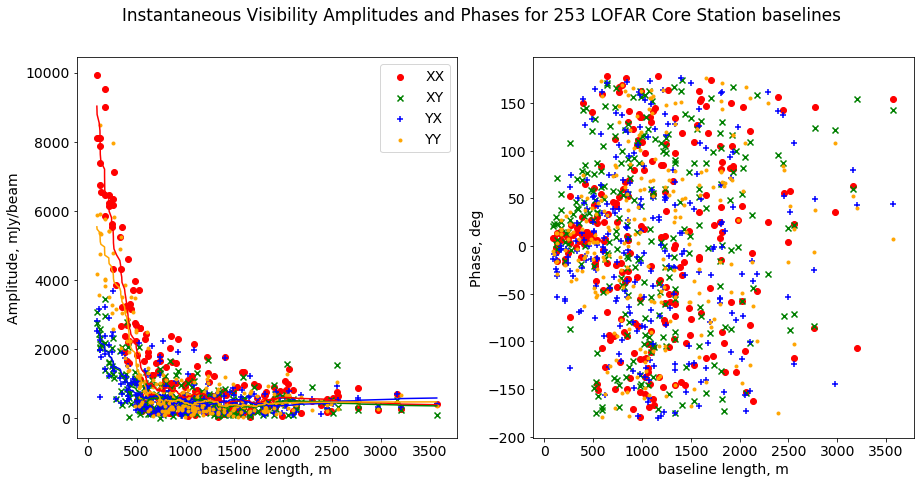

In [498]:
#Plot the amplitude and phase of the visibilities for a single timestep
timeind=26000
fig=plt.figure(figsize=(15,7))
fig.suptitle('Instantaneous Visibility Amplitudes and Phases for 253 LOFAR Core Station baselines')

#Create a mean model from the amplitudes as a function of baseline length.
#Then remove it so as not to bias the K-Means selection.
from scipy.signal import savgol_filter
blsid=np.argsort(dr)
drs=dr[blsid]
xxsg=savgol_filter(ampxx.loc[timeind].values[blsid],51,2)
xysg=savgol_filter(ampxy.loc[timeind].values[blsid],51,2)
yxsg=savgol_filter(ampyx.loc[timeind].values[blsid],51,2)
yysg=savgol_filter(ampyy.loc[timeind].values[blsid],51,2)



#Plot the magnitude of the XX observations
ax1 = fig.add_subplot(121)
ax1.set_xlabel('baseline length, m')
ax1.set_ylabel('Amplitude, mJy/beam')
ax1.scatter(dr,ampxx.loc[timeind].values,marker='o',color='red',label='XX')
ax1.plot(drs,xxsg, color='red')
ax1.scatter(dr,ampxy.loc[timeind].values,marker='x',color='green',label='XY')
ax1.plot(drs,xysg, color='green')
ax1.scatter(dr,ampyx.loc[timeind].values,marker='+',color='blue',label='YX')
ax1.plot(drs,yxsg, color='blue')
ax1.scatter(dr,ampyy.loc[timeind].values,marker='.',color='orange',label='YY')
ax1.plot(drs,yysg, color='orange')
ax1.legend()
#Plot the phase angle of the XX observations
ax2 = fig.add_subplot(122)
ax2.scatter(dr,phaxx.loc[timeind].values*180./np.pi,marker='o',color='red',label='XX')
ax2.scatter(dr,phaxy.loc[timeind].values*180./np.pi,marker='x',color='green',label='XY')
ax2.scatter(dr,phayx.loc[timeind].values*180./np.pi,marker='+',color='blue',label='YX')
ax2.scatter(dr,phayy.loc[timeind].values*180./np.pi,marker='.',color='orange',label='YY')
ax2.set_xlabel('baseline length, m')
ax2.set_ylabel('Phase, deg')

plt.savefig(plotsavedir+'instantaneous_visibilities_allbaselines.png',bbox_inches='tight')
plt.show()
plt.close(fig)

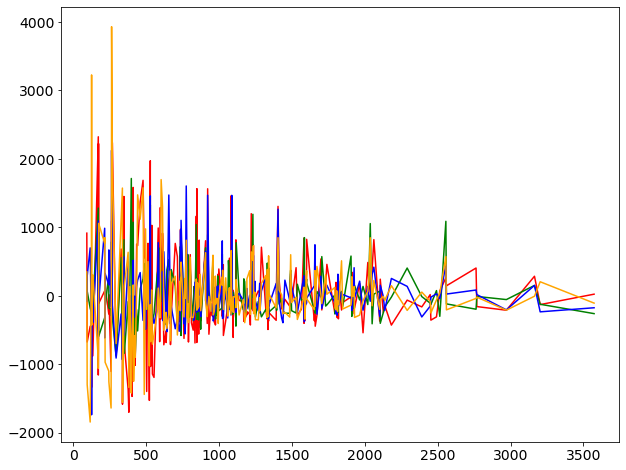

In [496]:
#Plot the amplitudes after removing a mean model as a function of baseline distance.

#plt.plot(drs,ampxx.loc[timeind].values[blsid])
plt.plot(drs,ampxx.loc[timeind].values[blsid]-xxsg, color='red')
plt.plot(drs,ampxy.loc[timeind].values[blsid]-xysg, color='green')
plt.plot(drs,ampyx.loc[timeind].values[blsid]-yxsg, color='blue')
plt.plot(drs,ampyy.loc[timeind].values[blsid]-yysg, color='orange')

In [499]:
ampxx

CS001LBA_CS002LBA  CS001LBA_CS003LBA  CS001LBA_CS004LBA  \
0           1.863146e+03       1.252585e+03       2.643970e+03   
1           1.627969e+03       1.219951e+03       2.553826e+03   
2           1.966299e+03       1.684765e+03       2.702241e+03   
3           2.077001e+03       1.351664e+03       2.815715e+03   
4           1.625031e+03       1.360665e+03       2.550991e+03   
...                  ...                ...                ...   
57515       3.314916e+07       3.546353e+07       5.185897e+07   
57516       2.135196e+07       2.049306e+07       3.690535e+07   
57517       3.972132e+07       6.683813e+06       4.447690e+07   
57518       3.040646e+07       1.297784e+07       4.973867e+07   
57519       4.995016e+07       1.742374e+07       4.259277e+07   

       CS001LBA_CS005LBA  CS001LBA_CS006LBA  CS001LBA_CS007LBA  \
0           2.483062e+03       1.328440e+03       1.688666e+03   
1           2.698284e+03       1.479097e+03       1.517513e+03   
2           2.604966e+03       1.536211e+03       1.350658e+03   
3           2.758168e+03       1.727406e+03       1.392613e+03   
4           2.688926e+03       1.591938e+03       1.516908e+03   
...                  ...                ...                ...   
57515       6.324342e+07       6.434772e+07       3.737058e+07   
57516       8.418885e+07       5.920694e+07       4.930821e+07   
57517       6.550544e+07       5.861730e+07       3.140223e+07   
57518       6.889207e+07       5.179672e+07       4.781365e+07   
57519       6.765683e+07       5.505134e+07       4.551962e+07   

       CS001LBA_CS011LBA  CS001LBA_CS013LBA  CS001LBA_CS017LBA  \
0           9.905151e+02       5.058206e+02       3.211590e+02   
1           1.272414e+03       6.481227e+02       2.983909e+02   
2           1.073732e+03       8.129343e+02       3.145166e+02   
3           1.471560e+03       1.143294e+03       3.680862e+02   
4           1.113249e+03       1.123492e+03       4.433188e+02   
...                  ...                ...                ...   
57515       8.952784e+07       2.288093e+07       2.591131e+07   
57516       7.388858e+07       3.129013e+07       3.086442e+07   
57517       5.784098e+07       3.424417e+07       5.856504e+06   
57518       6.662654e+07       1.395399e+07       9.389877e+06   
57519       8.472943e+07       5.021966e+07       3.508506e+07   

       CS001LBA_CS021LBA  ...  CS103LBA_CS201LBA  CS103LBA_CS302LBA  \
0           5.575388e+02  ...       6.717271e+02       1.477609e+02   
1           7.009829e+02  ...       5.159659e+02       1.926257e+02   
2           3.649402e+02  ...       2.455366e+02       4.002097e+02   
3           6.278921e+02  ...       5.342910e+02       3.106781e+02   
4           4.855935e+02  ...       1.389594e+02       4.846417e+01   
...                  ...  ...                ...                ...   
57515       2.314847e+07  ...       2.440374e+07       1.686144e+07   
57516       2.301753e+07  ...       1.240643e+07       2.310135e+07   
57517       2.107614e+07  ...       2.954454e+07       2.048537e+07   
57518       3.490073e+07  ...       2.516906e+07       5.131579e+07   
57519       1.637840e+07  ...       4.237590e+07       2.207537e+07   

       CS103LBA_CS401LBA  CS103LBA_CS501LBA  CS201LBA_CS302LBA  \
0           5.440692e+02       7.126194e+02       5.019590e+02   
1           2.661001e+02       3.780155e+02       7.623779e+02   
2           2.213270e+02       8.646630e+02       1.777652e+02   
3           1.822147e+02       3.749328e+02       4.512397e+02   
4           4.090627e+02       3.326715e+02       1.728753e+02   
...                  ...                ...                ...   
57515       2.287781e+07       3.354370e+07       2.182072e+07   
57516       2.595792e+07       1.723897e+07       2.535420e+07   
57517       1.832457e+07       3.722289e+06       3.420346e+05   
57518       2.031167e+07       7.974034e+06       2.098299e+07   
57519       2.146066e+07       7.250936e+06      

# 3. Evaluate the K-Means clustering algorithm to determine the k-number

In [430]:
#Evaluate K-Means for 2 features/dimensions - XX amplitude and phase
inertias = []
chscores = []
sscores = []

for tt in range(0,50000,1000):
    xxamp=ampxx.loc[tt].values
    xxphase=phaxx.loc[tt].values
    data = np.array(list(zip(xxamp,xxphase)))
    data_scaled = scaler.fit_transform(data)

    sum_of_squared_distances = []
    chscore = []
    sscore = []
    K = range(2,15)
    for k in K:
        kmeans = cluster.KMeans(n_clusters=k)
        model = kmeans.fit(data_scaled)
        labels = kmeans.labels_
        sum_of_squared_distances.append(kmeans.inertia_)
        sscore.append(metrics.silhouette_score(data_scaled, labels, metric = 'euclidean'))
        chscore.append(metrics.calinski_harabasz_score(data_scaled, labels))
    inertias.append(sum_of_squared_distances)
    chscores.append(chscore)
    sscores.append(sscore)

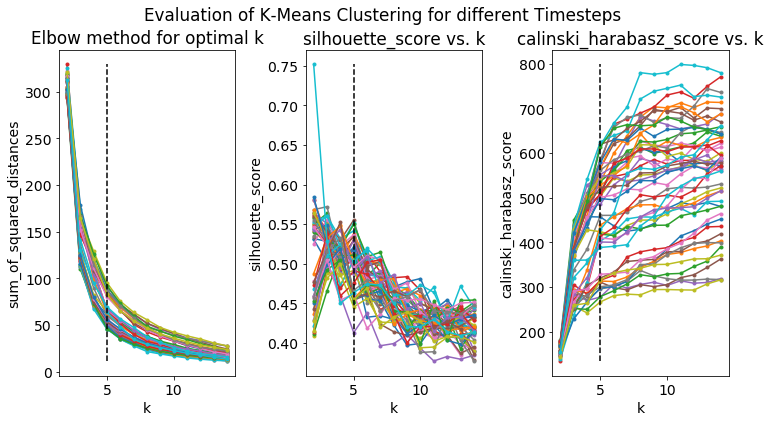

In [348]:
#Plot K-Means evaluation
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
plt.suptitle('Evaluation of K-Means Clustering for different Timesteps')
plt.subplot(131)
for inertia in inertias: plt.plot(K, inertia,marker='.')
plt.plot([5,5],[np.nanmin(inertias),np.nanmax(inertias)],linestyle='--',color='black')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.subplot(132)
for sscore in sscores: plt.plot(K, sscore,marker='.')
plt.plot([5,5],[np.nanmin(sscores),np.nanmax(sscores)],linestyle='--',color='black')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette_score vs. k')
plt.subplot(133)
for chscore in chscores: plt.plot(K, chscore, marker='.')
plt.plot([5,5],[np.nanmin(chscores),np.nanmax(chscores)],linestyle='--',color='black')
plt.xlabel('k')
plt.ylabel('calinski_harabasz_score')
plt.title('calinski_harabasz_score vs. k')
fig.subplots_adjust(wspace=.4)
plt.savefig(plotsavedir+'k_value_comparisons.png',bbox_inches='tight')
plt.show()

# 4. Calculate the visibility cutoffs for different K-Means applications

## 4.1 Run K-Means for 1 feature - XX amplitude

In [455]:
## 4.1 Run K-Means for 1 feature XX amplitude
ntimes=len(ampxxmean)
vmax=[]
for tt in range(ntimes):
    xxamp=ampxx.loc[tt].values.reshape(-1, 1)
    data = np.array(xxamp)
    data_scaled = scaler.fit_transform(data)
    kmeans=cluster.KMeans(n_clusters=5)
    model=kmeans.fit(data_scaled)
    # Get cluster assignment labels
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    u_labels=cluster_centers[:,0].argsort()
    vmax.append(np.nanmax(data[labels == u_labels[1]]))

vdf=pd.DataFrame(vmax)
vdf.to_pickle(savedir+'visibility_cutoff_xx_v0.p')

plotrun=False
if plotrun is True:
    plotdata=xxamp
    corrstr='XX'
    verstr='v0'
    nbaselines=plotdata.shape[0]
    baselines=np.arange(nbaselines)
    colors=['r','g','b','orange','c']
    for u_label in u_labels:
        print(u_label)
        print(np.nanmean(plotdata[labels == u_label]))
        plt.scatter(baselines[labels == u_label],plotdata[labels == u_label],c=colors[u_label],label=u_label)
    plt.xlabel('baselines')
    plt.ylabel('Visibility Amplitude')
    plt.title('LOFAR baselines vs. '+corrstr+' |Visibility|')
    plt.legend()
    plt.savefig('baselines_visibility_clusters_1features_'+verstr+'_'+corrstr+'.png',bbox_inches='tight')


In [ ]:
#UPDATE THE FLAG TABLE OF THE MS DATA BASED ON THE VIS MAGNITUDE CUT-OFFS - ONLY FOR XX correlation

#Set this to True to do the update
update_MS_flags = True

if update_MS_flags:
    vmax=pd.read_pickle(savedir+'visibility_cutoff_xx_v0.p')
    ntimes=vmax.shape[0]
    
    # to flag the data you could update the flag column, you might want to keep the old flags however in order to be able to convert back
    myt = pt.table(outms_v1,readonly=False)
    flags = myt.getcol("FLAG")
    desc=myt.getcoldesc("FLAG")
    cdata = myt.getcol("CORRECTED_DATA")
    
    newflags=flags.copy()
    stride=630 #the number of antenna station combinations in this MS
    #Apply time-dependent cut-off flagging
    for tt in range(ntimes):
        newflags[tt*stride:(tt+1)*stride,0,0] = np.abs(cdata[tt*stride:(tt+1)*stride,0,0]) > vmax.values[tt][0]
    newflags = np.logical_or(flags,newflags)
    if "ORIGFLAGS" in myt.colnames():
        print ("column ORIGFLAGS already existing, not overwriting")
    else:
        desc['name']="ORIGFLAGS"
        myt.addcols(desc)
        myt.putcol("ORIGFLAGS",flags)
        myt.putcol("FLAG",newflags)
    myt.close()
    

#The corresponding wsclean command for run v1
# wsclean -j 40 -mem 80 -no-reorder -no-update-model-required -mgain 0.6 -weight briggs 1 -multiscale -maxuvw-m 3200 -size 2048 2048 -scale 15asec  -pol I -data-column CORRECTED_DATA -niter 3000 -intervals-out 4 -interval  1 50520 -fit-beam -name /data001/scratch/kkozarev/EVENT_20170804/fits_50MHz/v0/SB154-viscutoff_v0 /data001/scratch/kkozarev/EVENT_20170804/MS/SUN/L602826_SAP000_SB154_uv_autoweight.MS

## 4.2 Run K-Means for 2 features/dimensions - XX amplitude and phase

In [ ]:
# Run K-Means for 2 features/dimensions - XX amplitude and phase
ntimes=len(ampxxmean)
vmax=[]
for tt in range(ntimes):
    #Evaluate K-Means for 2 features/dimensions - XX amplitude and phase
    xxamp=ampxx.loc[tt].values
    xxphase=np.abs(phaxx.loc[tt].values)
    data = np.array(list(zip(xxamp,xxphase)))
    data_scaled = scaler.fit_transform(data)
    kmeans=cluster.KMeans(n_clusters=5)
    model=kmeans.fit(data_scaled)
    # Get cluster assignment labels
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    u_labels=cluster_centers[:,0].argsort()
    vmax.append(np.nanmax(data[labels == u_labels[3]]))
vdf=pd.DataFrame(vmax)
vdf.to_pickle(savedir+'visibility_cutoff_xx_v1.p')

plotrun=False
if plotrun is True:
    plotdata=xxphase
    corrstr='XX'
    verstr='v1'
    ylabel='Visibility Amplitude'
    nbaselines=plotdata.shape[0]
    baselines=np.arange(nbaselines)
    colors=['r','g','b','orange','c']
    for u_label in u_labels:
        plt.scatter(baselines[labels == u_label],plotdata[labels == u_label],c=colors[u_label],label=u_label)
    plt.xlabel('baselines')
    plt.ylabel(ylabel)
    plt.title('LOFAR baselines vs. '+corrstr+' '+ylabel)
    plt.legend()
    plt.savefig(plotsavedir+'baselines_visibility_clusters_2features_'+verstr+'_'+corrstr+'.png',bbox_inches='tight')

In [444]:
#UPDATE THE FLAG TABLE OF THE MS DATA BASED ON THE VIS MAGNITUDE CUT-OFFS - ONLY FOR XX correlation
import numpy as np
import pickle
import casacore
import casacore.tables as pt
import pandas as pd
date='20170804'
#fname = "/data001/scratch/kkozarev/EVENT_20170804/MS/SUN/L602826_SAP000_SB052_uv_autoweight.MS"
#basedir='/data001/scratch/kkozarev/EVENT_20170804/'
#savedir=basedir+'fits_50MHz/'
basedir='/data/LOFAR/'+date+'/'
outms = basedir+"L602826_SAP000_SB154_uv_autoweight_v1.MS"
savedir=basedir+'viscutoff/'
plotsavedir=savedir

#Set this to True to do the update
update_MS_flags = True

if update_MS_flags:
    vmax=pd.read_pickle(savedir+'visibility_cutoff_xx_v1.p')
    ntimes=vmax.shape[0]
    
    # to flag the data you could update the flag column, you might want to keep the old flags however in order to be able to convert back
    myt = pt.table(outms,readonly=False)
    flags = myt.getcol("FLAG")
    desc=myt.getcoldesc("FLAG")
    cdata = myt.getcol("CORRECTED_DATA")
    
    newflags=flags.copy()
    stride=630 #the number of antenna station combinations in this MS
    #Apply time-dependent cut-off flagging
    for tt in range(ntimes):
        newflags[tt*stride:(tt+1)*stride,0,0] = np.abs(cdata[tt*stride:(tt+1)*stride,0,0]) > vmax.values[tt][0]
    newflags = np.logical_or(flags,newflags)
    if "ORIGFLAGS" in myt.colnames():
        print ("column ORIGFLAGS already existing, not overwriting")
    else:
        desc['name']="ORIGFLAGS"
        myt.addcols(desc)
        myt.putcol("ORIGFLAGS",flags)
        myt.putcol("FLAG",newflags)
    myt.close()
    

#The corresponding wsclean command for run v1
# wsclean -j 40 -mem 80 -no-reorder -no-update-model-required -mgain 0.6 -weight briggs 1 -multiscale -maxuvw-m 3200 -size 2048 2048 -scale 15asec  -pol I -data-column CORRECTED_DATA -niter 3000 -intervals-out 4 -interval  1 50520 -fit-beam -name /data001/scratch/kkozarev/EVENT_20170804/fits_50MHz/v1/SB154-viscutoff_v1 /data001/scratch/kkozarev/EVENT_20170804/MS/SUN/L602826_SAP000_SB154_uv_autoweight.MS
# wsclean -j 40 -mem 80 -no-reorder -no-update-model-required -mgain 0.6 -weight briggs 1 -multiscale -maxuvw-m 3200 -size 2048 2048 -scale 15asec  -pol I -data-column CORRECTED_DATA -niter 3000 -intervals-out 4 -interval  1 50520 -fit-beam -name /data/LOFAR/20170804/imaging/fits_50MHz/v1/SB154-viscutoff_v1 /data/LOFAR/20170804/L602826_SAP000_SB154_uv_autoweight_v1.MS


Successful read/write open of default-locked table /data/LOFAR/20170804/L602826_SAP000_SB154_uv_autoweight_v1.MS: 27 columns, 36237600 rows


## 4.3 Run K-Means for 4 features/dimensions - XX, XY, YX, YY amplitudes

In [456]:
#Run K-Means for 4 features/dimensions - XX, XY, YX, YY amplitudes
ntimes=len(ampxxmean)
vmax=[]
for tt in range(ntimes):
    xxamp=ampxx.loc[tt].values
    xyamp=ampxy.loc[tt].values
    yxamp=ampyx.loc[tt].values
    yyamp=ampyy.loc[tt].values
    data_v2 = np.array(list(zip(yxamp,xxamp,xyamp,yyamp)))
    data_scaled_v2 = scaler.fit_transform(data_v2)
    kmeans_v2=cluster.KMeans(n_clusters=5)
    model=kmeans_v2.fit(data_scaled_v2)
    # Get cluster assignment labels
    labels_v2 = kmeans_v2.labels_
    cluster_centers_v2 = kmeans_v2.cluster_centers_
    u_labels_v2=cluster_centers_v2[:,0].argsort()
    np.nanmax(xyamp[labels_v2 == u_labels_v2[3]])
vdf=pd.DataFrame(vmax)
vdf.to_pickle(savedir+'visibility_cutoff_xx_v2.p')


plotrun=False
if plotrun is True:
    plotdata=xxamp
    corrstr='xx'
    verstr='v2'
    nbaselines=plotdata.shape[0]
    baselines=np.arange(nbaselines)
    colors=['r','g','b','orange','c']
    for u_label in u_labels:
        print(u_label)
        print(np.nanmax(plotdata[labels == u_label]))
        plt.scatter(baselines[labels == u_label],plotdata[labels == u_label],c=colors[u_label],label=u_label)
    plt.xlabel('baselines')
    plt.ylabel('Visibility Amplitude')
    plt.title('LOFAR baselines vs. '+corrstr+' |Visibility|')
    plt.legend()
    plt.savefig(plotsavedir+'baselines_visibility_clusters_4features_'+verstr+'_'+corrstr+'.png',bbox_inches='tight')

In [ ]:
#UPDATE THE FLAG TABLE OF THE MS DATA BASED ON THE VIS MAGNITUDE CUT-OFFS - ONLY FOR XX correlation

#Set this to True to do the update
update_MS_flags = True

if update_MS_flags:
    vmax=pd.read_pickle(savedir+'visibility_cutoff_xx_v2.p')
    ntimes=vmax.shape[0]
    
    # to flag the data you could update the flag column, you might want to keep the old flags however in order to be able to convert back
    myt = pt.table(outms,readonly=False)
    flags = myt.getcol("FLAG")
    desc=myt.getcoldesc("FLAG")
    cdata = myt.getcol("CORRECTED_DATA")
    
    newflags=flags.copy()
    stride=630 #the number of antenna station combinations in this MS
    #Apply time-dependent cut-off flagging
    for tt in range(ntimes):
        newflags[tt*stride:(tt+1)*stride,0,0] = np.abs(cdata[tt*stride:(tt+1)*stride,0,0]) > vmax.values[tt][0]
    newflags = np.logical_or(flags,newflags)
    if "ORIGFLAGS" in myt.colnames():
        print ("column ORIGFLAGS already existing, not overwriting")
        myt.putcol("FLAG",newflags)
    else:
        desc['name']="ORIGFLAGS"
        myt.addcols(desc)
        myt.putcol("ORIGFLAGS",flags)
        myt.putcol("FLAG",newflags)
    myt.close()
    

#The corresponding wsclean command for run v2
# wsclean -j 40 -mem 80 -no-reorder -no-update-model-required -mgain 0.6 -weight briggs 1 -multiscale -maxuvw-m 3200 -size 2048 2048 -scale 15asec  -pol I -data-column CORRECTED_DATA -niter 3000 -intervals-out 4 -interval  1 50520 -fit-beam -name /data001/scratch/kkozarev/EVENT_20170804/fits_50MHz/v2/SB154-viscutoff_v2 /data001/scratch/kkozarev/EVENT_20170804/MS/SUN/L602826_SAP000_SB154_uv_autoweight.MS
# wsclean -j 40 -mem 80 -no-reorder -no-update-model-required -mgain 0.6 -weight briggs 1 -multiscale -maxuvw-m 3200 -size 2048 2048 -scale 15asec  -pol I -data-column CORRECTED_DATA -niter 3000 -intervals-out 4 -interval  1 50520 -fit-beam -name /data/LOFAR/20170804/imaging/fits_50MHz/v2/SB154-viscutoff_v2 /data/LOFAR/20170804/L602826_SAP000_SB154_uv_autoweight_v1.MS



## 4.4 Run K-Means for 4 features/dimensions - XX, XY, YX, YY phases

In [457]:
# Run K-Means for 4 features/dimensions - XX, XY, YX, YY phases
ntimes=len(ampxxmean)
vmax=[]
for tt in range(ntimes):
    xxphase=np.abs(phaxx.loc[tt].values)
    xyphase=np.abs(phaxy.loc[tt].values)
    yxphase=np.abs(phayx.loc[tt].values)
    yyphase=np.abs(phayy.loc[tt].values)
    data_v3 = np.array(list(zip(yyphase,xxphase,xyphase,yxphase)))
    data_scaled_v3 = scaler.fit_transform(data_v3)
    kmeans_v3=cluster.KMeans(n_clusters=5)
    model=kmeans_v3.fit(data_scaled_v3)
    # Get cluster assignment labels
    labels_v3 = kmeans_v3.labels_
    cluster_centers_v3 = kmeans_v3.cluster_centers_
    u_labels_v3=cluster_centers_v3[:,0].argsort()
    vmax.append(np.nanmax(xyamp[labels_v3 == u_labels_v3[3]]))

vdf=pd.DataFrame(vmax)
vdf.to_pickle(savedir+'visibility_cutoff_xx_v3.p')

plotrun=False
if plotrun is True:
    plotdata=xxphase
    corrstr='XX'
    verstr='v3'
    ylabel='Visibility Phase'
    nbaselines=plotdata.shape[0]
    baselines=np.arange(nbaselines)
    colors=['r','g','b','orange','c']
    for u_label in u_labels:
        plt.scatter(baselines[labels == u_label],plotdata[labels == u_label],c=colors[u_label],label=u_label)
        #plt.scatter(xxphase[labels == u_label],yxphase[labels == u_label],c=colors[u_label],label=u_label)
    plt.xlabel('baselines')
    plt.ylabel(ylabel)
    plt.title('LOFAR baselines vs. '+corrstr+' '+ylabel)
    plt.legend()
    plt.savefig(plotsavedir+'baselines_visibility_clusters_4features_'+verstr+'_'+corrstr+'.png',bbox_inches='tight')

In [ ]:
#UPDATE THE FLAG TABLE OF THE MS DATA BASED ON THE VIS MAGNITUDE CUT-OFFS - ONLY FOR XX correlation

#Set this to True to do the update
update_MS_flags = True

if update_MS_flags:
    vmax=pd.read_pickle(savedir+'visibility_cutoff_xx_v3.p')
    ntimes=vmax.shape[0]
    
    # to flag the data you could update the flag column, you might want to keep the old flags however in order to be able to convert back
    myt = pt.table(outms_v1,readonly=False)
    flags = myt.getcol("FLAG")
    desc=myt.getcoldesc("FLAG")
    cdata = myt.getcol("CORRECTED_DATA")
    
    newflags=flags.copy()
    stride=630 #the number of antenna station combinations in this MS
    #Apply time-dependent cut-off flagging
    for tt in range(ntimes):
        newflags[tt*stride:(tt+1)*stride,0,0] = np.abs(cdata[tt*stride:(tt+1)*stride,0,0]) > vmax.values[tt][0]
    newflags = np.logical_or(flags,newflags)
    if "ORIGFLAGS" in myt.colnames():
        print ("column ORIGFLAGS already existing, not overwriting")
    else:
        desc['name']="ORIGFLAGS"
        myt.addcols(desc)
        myt.putcol("ORIGFLAGS",flags)
        myt.putcol("FLAG",newflags)
    myt.close()
    

#The corresponding wsclean command for run v3
# wsclean -j 40 -mem 80 -no-reorder -no-update-model-required -mgain 0.6 -weight briggs 1 -multiscale -maxuvw-m 3200 -size 2048 2048 -scale 15asec  -pol I -data-column CORRECTED_DATA -niter 3000 -intervals-out 4 -interval  1 50520 -fit-beam -name /data001/scratch/kkozarev/EVENT_20170804/fits_50MHz/v3/SB154-viscutoff_v3 /data001/scratch/kkozarev/EVENT_20170804/MS/SUN/L602826_SAP000_SB154_uv_autoweight.MS
# wsclean -j 40 -mem 80 -no-reorder -no-update-model-required -mgain 0.6 -weight briggs 1 -multiscale -maxuvw-m 3200 -size 2048 2048 -scale 15asec  -pol I -data-column CORRECTED_DATA -niter 3000 -intervals-out 4 -interval  1 50520 -fit-beam -name /data/LOFAR/20170804/imaging/fits_50MHz/v3/SB154-viscutoff_v3 /data/LOFAR/20170804/L602826_SAP000_SB154_uv_autoweight_v1.MS


## 4.4 K-Means for 4 features/dimensions - XX amplitude and phase, YY amplitude and phase

In [458]:
#Run K-Means for 4 features/dimensions - XX amplitude and phase, YY amplitude and phase
ntimes=len(ampxxmean)
vmax=[]
for tt in range(ntimes):
    xxamp=ampxx.loc[tt].values
    xxphase=np.abs(phaxx.loc[tt].values)
    xyamp=ampxy.loc[tt].values
    xyphase=np.abs(phaxy.loc[tt].values)
    data_v4 = np.array(list(zip(xxamp,xyamp,xxphase,xyphase)))
    data_scaled_v4 = scaler.fit_transform(data_v4)
    kmeans_v4=cluster.KMeans(n_clusters=5)
    model_v4=kmeans_v4.fit(data_scaled_v4)
    # Get cluster assignment labels
    labels_v4 = kmeans_v4.labels_
    cluster_centers_v4 = kmeans_v4.cluster_centers_
    u_labels_v4=cluster_centers_v4[:,0].argsort()
    vmax.append(np.nanmax(data_v4[labels == u_labels_v4[3]]))
vdf=pd.DataFrame(vmax)
vdf.to_pickle(savedir+'visibility_cutoff_xx_v4.p')

plotrun=False
if plotrun is True:
    plotdata=xxamp
    corrstr='XX'
    verstr='v4'
    nbaselines=plotdata.shape[0]
    baselines=np.arange(nbaselines)
    colors=['r','g','b','orange','c']
    for u_label in u_labels:
        print(u_label)
        print(np.nanmean(plotdata[labels == u_label]))
        plt.scatter(baselines[labels == u_label],plotdata[labels == u_label],c=colors[u_label],label=u_label)
    plt.xlabel('baselines')
    plt.ylabel('Visibility Amplitude')
    plt.title('LOFAR baselines vs. '+corrstr+' |Visibility|')
    plt.legend()
    plt.savefig('baselines_visibility_clusters_4features_'+verstr+'_'+corrstr+'.png',bbox_inches='tight')


In [ ]:
#UPDATE THE FLAG TABLE OF THE MS DATA BASED ON THE VIS MAGNITUDE CUT-OFFS - ONLY FOR XX correlation

#Set this to True to do the update
update_MS_flags = True

if update_MS_flags:
    vmax=pd.read_pickle(savedir+'visibility_cutoff_xx_v4.p')
    ntimes=vmax.shape[0]
    
    # to flag the data you could update the flag column, you might want to keep the old flags however in order to be able to convert back
    myt = pt.table(outms_v1,readonly=False)
    flags = myt.getcol("FLAG")
    desc=myt.getcoldesc("FLAG")
    cdata = myt.getcol("CORRECTED_DATA")
    
    newflags=flags.copy()
    stride=630 #the number of antenna station combinations in this MS
    #Apply time-dependent cut-off flagging
    for tt in range(ntimes):
        newflags[tt*stride:(tt+1)*stride,0,0] = np.abs(cdata[tt*stride:(tt+1)*stride,0,0]) > vmax.values[tt][0]
    newflags = np.logical_or(flags,newflags)
    if "ORIGFLAGS" in myt.colnames():
        print ("column ORIGFLAGS already existing, not overwriting")
    else:
        desc['name']="ORIGFLAGS"
        myt.addcols(desc)
        myt.putcol("ORIGFLAGS",flags)
        myt.putcol("FLAG",newflags)
    myt.close()
    

#The corresponding wsclean command for run v4
# wsclean -j 40 -mem 80 -no-reorder -no-update-model-required -mgain 0.6 -weight briggs 1 -multiscale -maxuvw-m 3200 -size 2048 2048 -scale 15asec  -pol I -data-column CORRECTED_DATA -niter 3000 -intervals-out 4 -interval  1 50520 -fit-beam -name /data001/scratch/kkozarev/EVENT_20170804/fits_50MHz/v4/SB154-viscutoff_v4 /data001/scratch/kkozarev/EVENT_20170804/MS/SUN/L602826_SAP000_SB154_uv_autoweight.MS
# wsclean -j 40 -mem 80 -no-reorder -no-update-model-required -mgain 0.6 -weight briggs 1 -multiscale -maxuvw-m 3200 -size 2048 2048 -scale 15asec  -pol I -data-column CORRECTED_DATA -niter 3000 -intervals-out 4 -interval  1 50520 -fit-beam -name /data/LOFAR/20170804/imaging/fits_50MHz/v4/SB154-viscutoff_v4 /data/LOFAR/20170804/L602826_SAP000_SB154_uv_autoweight_v1.MS



# 5. Plot the |Visibility| minimum, mean, maximum, and cut-offs - ONLY FOR XX

<ipython-input-454-f2c4a6bd5a51>:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(plotsavedir+'visibility_amplitude_cutoffs_'+corrstr+'_'+verstr+'.png',bbox_inches='tight')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


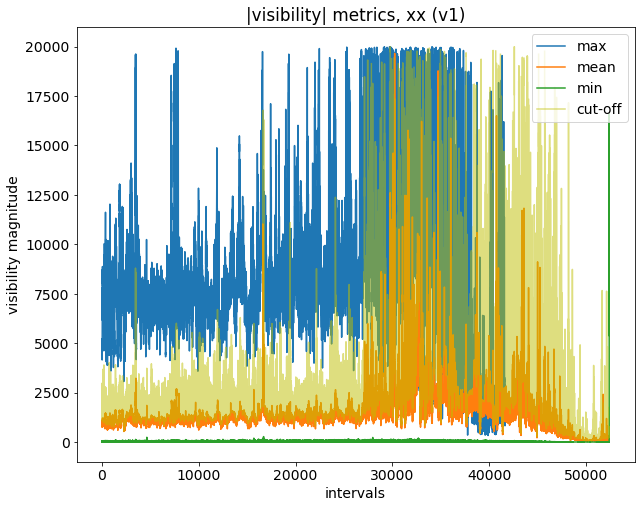

In [454]:
#Plot the |Vis| minimum,mean,maximum, and cut-offs - ONLY FOR XX
plot_cutoffs=True
if plot_cutoffs is True:
    verstr='v1'
    corrstr='xx'
    cutoffname=savedir+'visibility_cutoff_'+corrstr+'_'+verstr+'.p'
    vmax=pd.read_pickle(cutoffname)
    origmax=ampxx.max(axis=1).values
    origmean=ampxx.mean(axis=1).values
    origmin=ampxx.min(axis=1).values
    plt.figure(figsize=[10,8])
    plt.plot(origmax[origmax < 2.e4],label='max')
    plt.plot(origmean[origmean < 2.e4],label='mean')
    plt.plot(origmin[origmin < 2.e4],label='min')
    plt.plot(vmax[vmax < 2.e4],label='cut-off',alpha=0.5,c='y')
    plt.xlabel('intervals')
    plt.ylabel('visibility magnitude')
    plt.title('|visibility| metrics, '+corrstr+' ('+verstr+')')
    plt.legend()
    plt.savefig(plotsavedir+'visibility_amplitude_cutoffs_'+corrstr+'_'+verstr+'.png',bbox_inches='tight')